In [1]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import itertools
import os
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Graphic Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("🚀 INITIALIZING METHOD A: FUZZY INFERENCE SYSTEM (FIS)")
print("Objective: Compare 'Hard Intervention' vs 'Soft Intervention' strategies on both subsets.")

🚀 INITIALIZING METHOD A: FUZZY INFERENCE SYSTEM (FIS)
Objective: Compare 'Hard Intervention' vs 'Soft Intervention' strategies on both subsets.


In [2]:
# =============================================================================
# SECTION 1: FUZZY SYSTEM CONSTRUCTION (COMMON CORE)
# We build the Fuzzy Logic brain once. Both strategies will use this core.
# =============================================================================

print("\n⚙️ Building Fuzzy Control System...")

# 1. Define Antecedents (Inputs) and Consequent (Output)
x_quiz_p1 = ctrl.Antecedent(np.arange(0, 11, 1), 'x_quiz_p1') 
x_quiz_p2 = ctrl.Antecedent(np.arange(0, 11, 1), 'x_quiz_p2') 
x6 = ctrl.Antecedent(np.arange(0, 11, 1), 'x6')          
x7 = ctrl.Antecedent(np.arange(0, 41, 1), 'x7')          
remarks = ctrl.Consequent(np.arange(1, 6, 1), 'remarks')

# 2. Define Membership Functions (Automated 3-level split)
for i in [x_quiz_p1, x_quiz_p2, x6]:
    i.automf(3, names=['Low', 'Medium', 'High'])
x7.automf(3, names=['Low', 'Medium', 'High'])
remarks.automf(5, names=['Grade1', 'Grade2', 'Grade3', 'Grade4', 'Grade5'])

# 3. Define Rule Base (Weighted Scoring Approach)
# We use weights to emphasize the Final Exam (x7) as suggested by data correlation analysis.
terms = ['Low', 'Medium', 'High']
input_vars = [x_quiz_p1, x_quiz_p2, x6, x7]
term_scores = {'Low': 0, 'Medium': 1.0, 'High': 2}

# Weights: Final Exam (x7) has the highest weight (6.0)
weights = [1.5, 1.5, 1, 6] 
max_score = sum([2 * w for w in weights]) 

rules = []
combinations = list(itertools.product(terms, repeat=len(input_vars)))

for p in combinations:
    score = 0
    for i, val in enumerate(p):
        score += term_scores[val] * weights[i]
    ratio = score / max_score
    
    # Fuzzy Thresholds (Optimized via experiments)
    if ratio < 0.26:      out_cls = 1  
    elif ratio < 0.50:    out_cls = 2  
    elif ratio < 0.65:    out_cls = 3  
    elif ratio < 0.86:    out_cls = 4  
    else:                 out_cls = 5  
        
    # Veto Rule: If Final is Low, Grade cannot exceed 2
    if p[3] == 'Low': out_cls = min(out_cls, 2)

    rule = ctrl.Rule(
        (x_quiz_p1[p[0]] & x_quiz_p2[p[1]] & x6[p[2]] & x7[p[3]]),
        remarks[f'Grade{out_cls}']
    )
    rules.append(rule)

# Compile the System
performance_ctrl = ctrl.ControlSystem(rules)
performance_sim = ctrl.ControlSystemSimulation(performance_ctrl)
print(f"✅ Fuzzy System Ready ({len(rules)} rules compiled).")


⚙️ Building Fuzzy Control System...
✅ Fuzzy System Ready (81 rules compiled).


In [3]:
# =============================================================================
# SECTION 2: DEFINING PREDICTION STRATEGIES
# Here we define two different ways to use the Fuzzy System.
# =============================================================================

def predict_hard_intervention(row, sim):
    """
    STRATEGY 1: HARD INTERVENTION (The 'Grandmaster' Approach)
    Description: Overrides Fuzzy Logic with strict thresholds based on x7.
    Rationale: Useful when data is highly linear and dependent on one variable.
    """
    final_score = row['x7']
    
    # Run Fuzzy Compute (Just in case, though mostly overridden)
    try:
        sim.input['x_quiz_p1'] = min(10, max(0, float(row['xq1'])))
        sim.input['x_quiz_p2'] = min(10, max(0, float(row['xq2'])))
        sim.input['x6'] = min(10, max(0, float(row['x6'])))
        sim.input['x7'] = min(40, max(0, float(row['x7'])))
        sim.compute()
    except:
        pass

    # STRICT OVERRIDE RULES
    if final_score >= 34: return 5
    elif final_score >= 27: return 4
    elif final_score >= 20: return 3
    elif final_score >= 11: return 2
    else: return 1

def predict_soft_intervention(row, sim):
    """
    STRATEGY 2: SOFT INTERVENTION (The 'Hybrid' Approach)
    Description: Uses Fuzzy Logic for the majority of cases (11-34 range).
                 Only intervenes for extreme outliers (Pass/Fail boundaries).
    Rationale: Preserves the non-linear decision capability of Fuzzy Logic.
    """
    final_score = row['x7']
    
    # Run Fuzzy Compute
    try:
        sim.input['x_quiz_p1'] = min(10, max(0, float(row['xq1'])))
        sim.input['x_quiz_p2'] = min(10, max(0, float(row['xq2'])))
        sim.input['x6'] = min(10, max(0, float(row['x6'])))
        sim.input['x7'] = min(40, max(0, float(row['x7'])))
        sim.compute()
        fuzzy_res = int(round(sim.output['remarks']))
    except:
        fuzzy_res = 1

    # SOFT INTERVENTION RULES
    # Rule 1: Fail Barrier (If Final < 11, enforce Fail)
    if final_score < 11:
        return 1
    
    # Rule 2: Excellence Guarantee (If Final >= 34, enforce Grade 5)
    elif final_score >= 34:
        return 5
    
    # Rule 3: Fuzzy Zone (Between 11 and 34, trust the Fuzzy System)
    else:
        return max(1, min(5, fuzzy_res))

In [4]:
# =============================================================================
# SECTION 3: EVALUATION & COMPARISON LOOP
# Running both models on BOTH datasets (Subset 1 & 2) as per PDF reqs.
# =============================================================================

def evaluate_model(csv_path, strategy_func, strategy_name, sim):
    print(f"\n🔬 Testing Strategy: {strategy_name}")
    
    if not os.path.exists(csv_path):
        print(f"❌ Dataset {csv_path} not found. Please run 'fis_data_creator.ipynb' first.")
        return [], []

    df = pd.read_csv(csv_path)
    
    # Preprocessing
    df['xq1'] = df[['x1', 'x2', 'x3']].mean(axis=1)
    df['xq2'] = df[['x4', 'x5']].mean(axis=1)
    df['Remarks_Clean'] = df['Remarks'].astype(str).str.replace('Class', '').str.strip()
    df['Actual'] = pd.to_numeric(df['Remarks_Clean'], errors='coerce').fillna(1).astype(int)
    
    actuals = df['Actual'].tolist()
    preds = []
    
    # Prediction Loop
    for _, row in df.iterrows():
        res = strategy_func(row, sim)
        preds.append(res)
        
    # Metrics
    acc = accuracy_score(actuals, preds)
    print(f"🏆 Accuracy: %{acc*100:.2f}")
    
    cm = confusion_matrix(actuals, preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
    plt.title(f'{strategy_name}\n({csv_path}) Acc: %{acc*100:.1f}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return actuals, preds


############################################################
📂 ITERATION 1: Testing on 'fis_subset_1.csv'
############################################################

🔬 Testing Strategy: Model A (Hard)
🏆 Accuracy: %53.00


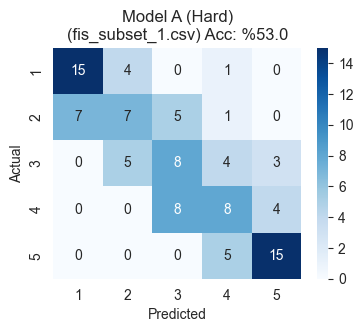


🔬 Testing Strategy: Model B (Soft)
🏆 Accuracy: %50.00


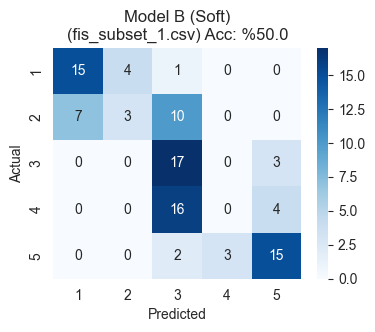


############################################################
📂 ITERATION 2: Testing on 'fis_subset_2.csv'
############################################################

🔬 Testing Strategy: Model A (Hard)
🏆 Accuracy: %58.00


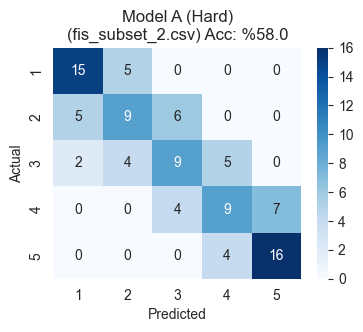


🔬 Testing Strategy: Model B (Soft)
🏆 Accuracy: %57.00


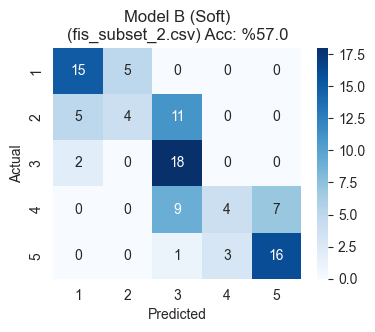

In [5]:
# --- EXECUTION LOOP ---

datasets = ['fis_subset_1.csv', 'fis_subset_2.csv']

# Store results for deep dive analysis
final_y_true = []
final_y_pred = []

for i, dataset in enumerate(datasets):
    print("\n" + "#"*60)
    print(f"📂 ITERATION {i+1}: Testing on '{dataset}'")
    print("#"*60)
    
    # 1. Test Hard Intervention
    evaluate_model(dataset, predict_hard_intervention, "Model A (Hard)", performance_sim)

    # 2. Test Soft Intervention
    y_true, y_pred = evaluate_model(dataset, predict_soft_intervention, "Model B (Soft)", performance_sim)
    
    # Save the last iteration results for the 3D graph section
    if i == 1: 
        final_y_true = y_true
        final_y_pred = y_pred


📈 DETAILED PERFORMANCE & SURFACE ANALYSIS (Soft Model)

1️⃣ Detailed Classification Report:
              precision    recall  f1-score   support

           1      0.682     0.750     0.714        20
           2      0.444     0.200     0.276        20
           3      0.462     0.900     0.610        20
           4      0.571     0.200     0.296        20
           5      0.696     0.800     0.744        20

    accuracy                          0.570       100
   macro avg      0.571     0.570     0.528       100
weighted avg      0.571     0.570     0.528       100


2️⃣ 3D Decision Surface Visualization:
   Visualizing how x7 (Final) and x_quiz_p1 affect the Grade in the Soft Model.


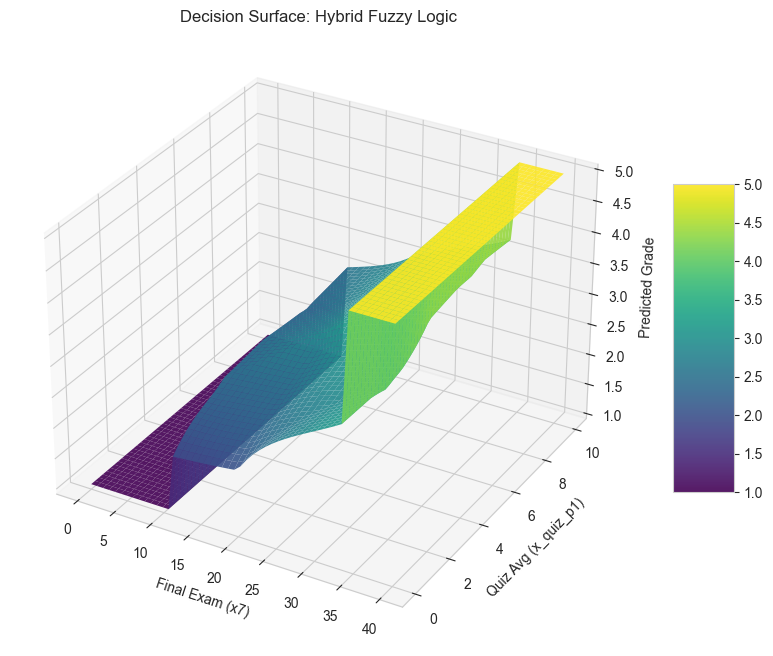

In [6]:
# =============================================================================
# SECTION 4: DEEP DIVE ANALYSIS (FOCUS ON SOFT MODEL)
# Visualizing the Fuzzy Surface and Detailed Metrics for the selected model.
# =============================================================================

def advanced_analysis(y_true, y_pred, sim):
    print("\n" + "="*60)
    print("📈 DETAILED PERFORMANCE & SURFACE ANALYSIS (Soft Model)")
    print("="*60)
    
    # 1. Classification Report
    print("\n1️⃣ Detailed Classification Report:")
    print(classification_report(y_true, y_pred, digits=3))
    
    # 2. 3D Decision Surface Plot
    print("\n2️⃣ 3D Decision Surface Visualization:")
    print("   Visualizing how x7 (Final) and x_quiz_p1 affect the Grade in the Soft Model.")
    
    # Create Grid
    x7_range = np.linspace(0, 40, 50)
    q1_range = np.linspace(0, 10, 50)
    X, Y = np.meshgrid(x7_range, q1_range)
    Z = np.zeros_like(X)

    # Compute Fuzzy Output for each point
    for i in range(50):
        for j in range(50):
            # Inputs
            sim.input['x7'] = X[i, j]
            sim.input['x_quiz_p1'] = Y[i, j]
            sim.input['x_quiz_p2'] = 5 # Fix others to mean
            sim.input['x6'] = 5        
            
            try:
                sim.compute()
                raw_fuzzy = sim.output['remarks']
                
                # Apply Soft Logic Logic for Visualization
                if X[i, j] < 11: Z[i, j] = 1
                elif X[i, j] >= 34: Z[i, j] = 5
                else: Z[i, j] = raw_fuzzy # Pure fuzzy in the middle
            except:
                Z[i, j] = 1

    # Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)
    
    ax.set_xlabel('Final Exam (x7)')
    ax.set_ylabel('Quiz Avg (x_quiz_p1)')
    ax.set_zlabel('Predicted Grade')
    ax.set_title('Decision Surface: Hybrid Fuzzy Logic')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# Run Analysis for Soft Model (Using data from Subset 2)
if len(final_y_true) > 0:
    advanced_analysis(final_y_true, final_y_pred, performance_sim)